## 數據來源與說明

https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009


| 特徵（Features）         | 說明              |
| -------------------- | --------------- |
| fixed acidity        | 固定酸度            |
| volatile acidity     | 揮發酸度            |
| citric acid          | 檸檬酸             |
| residual sugar       | 殘糖              |
| chlorides            | 氯化物含量           |
| free sulfur dioxide  | 游離二氧化硫          |
| total sulfur dioxide | 總二氧化硫           |
| density              | 密度              |
| pH                   | 酸鹼值             |
| sulphates            | 硫酸鹽             |
| alcohol              | 酒精濃度            |
| **quality**          | 目標欄位（品質分數，0~10） |




## 載入函式庫

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## 數據載入

In [2]:
def read_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("錯誤：找不到文件，請確認路徑或檔案名稱。")

In [3]:
file_path = r".\data\winequality-red.csv"
raw_data = read_csv(file_path)
print(f"原始數據數量: {raw_data.shape}")

原始數據數量: (1599, 12)


## 數據探勘

In [4]:
def plot_heatmap(data, file_name):
    plt.figure(figsize=(14, 8))
    sns.heatmap(data, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=0.5)
    plt.title('Wine Features Correlation Heatmap', fontsize=24)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()
    
def plot_boxplot(data, file_name):
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=data)
    plt.xticks(rotation=45)
    plt.title('Outlier Detection across Wine Features', fontsize=24)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()
    
def data_scaling(data):
    scale_by_minmax = MinMaxScaler().fit_transform(data)
    scale_by_zscore = StandardScaler().fit_transform(data)
    scale_data_dict={'minmax':scale_by_minmax,
                     'zscore':scale_by_zscore}
    return scale_data_dict

def plot_histograms(data_dict, file_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    sns.histplot(data_dict['minmax'], kde=True, ax=ax1, color='orange')
    ax1.set_title('Effect of MinMaxScaler\n(Outliers compress normal data)', fontsize=22)
    ax1.set_xlabel('Scaled Value (Min-Max Range)', fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    
    sns.histplot(data_dict['zscore'], kde=True, ax=ax2, color='skyblue')
    ax2.set_title('Effect of StandardScaler\n(Retains distribution despite outliers)', fontsize=22)
    ax2.set_xlabel('Z-Score (Number of Standard Deviations)', fontsize=14)
    ax2.set_ylabel('Count', fontsize=14)
    custom_ticks = sorted(list(set([-1, 1] + list(np.arange(-2, 8, 1)))))
    ax2.set_xticks(custom_ticks)
    
    ax2.axvline(-1, color='red', linestyle='--', alpha=0.6, label='-1 std')
    ax2.axvline(1, color='red', linestyle='--', alpha=0.6, label='+1 std')
    ax2.legend()
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()

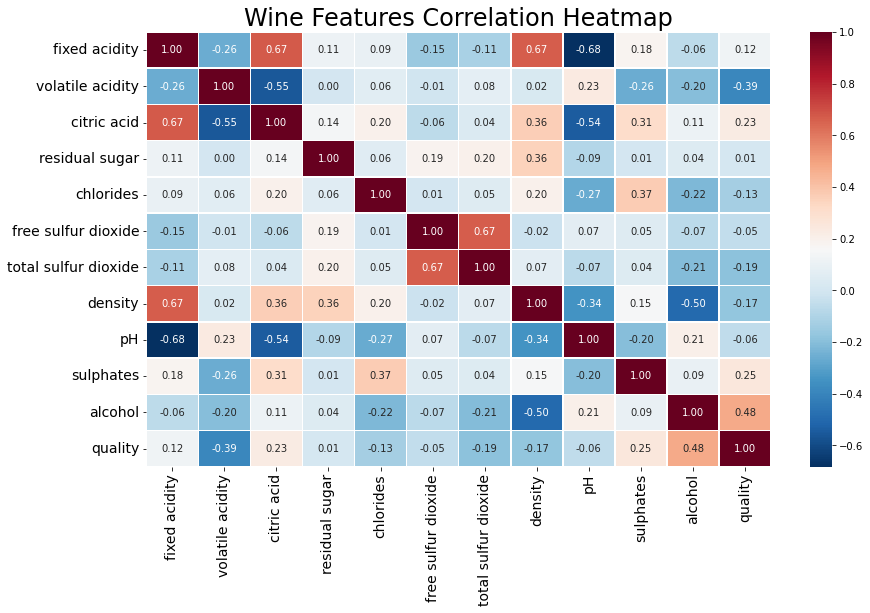

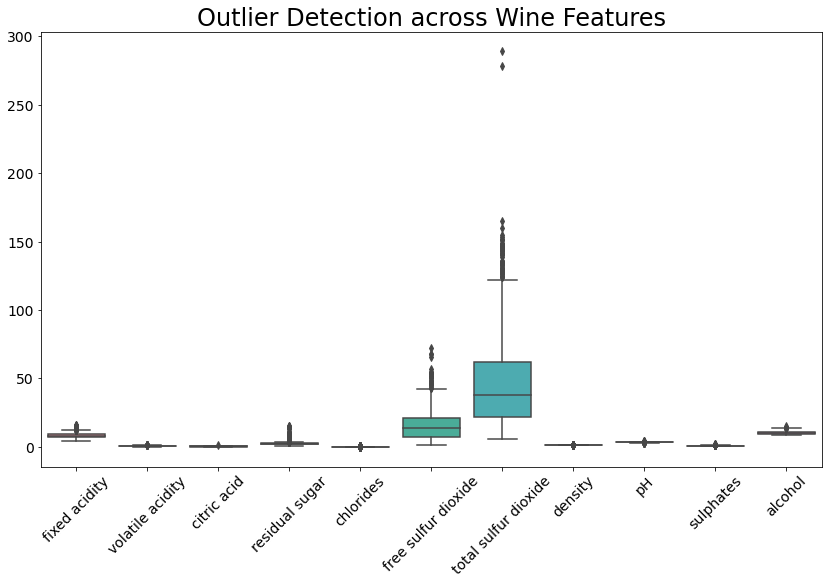

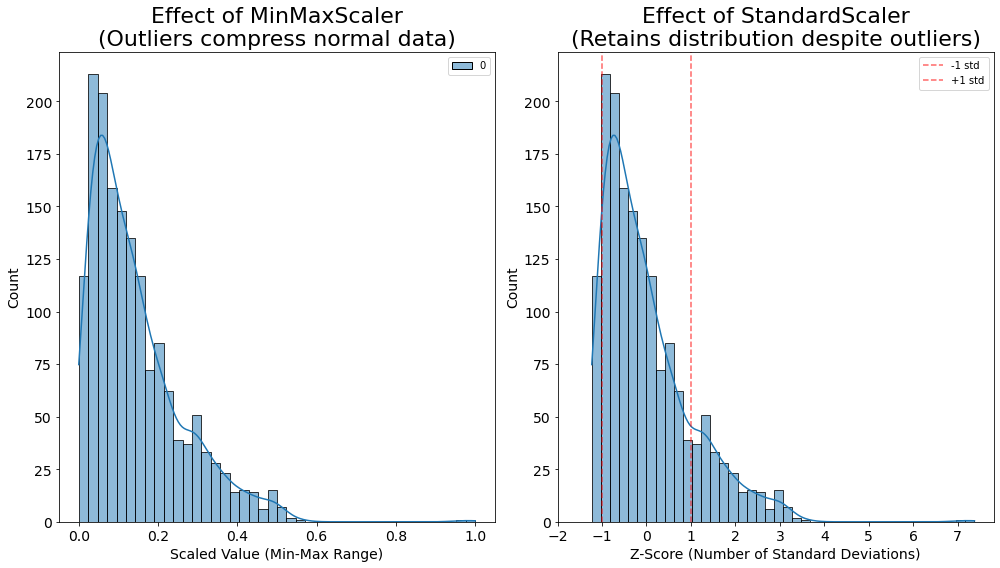

In [5]:
corr = raw_data.corr()
plot_heatmap(corr, file_name="corr_heatmap.png")
plot_boxplot(raw_data.drop('quality', axis=1) , file_name="outlier.png")
scale_data_dict = data_scaling(raw_data[['total sulfur dioxide']])
plot_histograms(scale_data_dict, file_name='scaling_theory_comparison.png')

## 數據預處理

In [6]:
def data_preprocessing(raw_data):
    # 排除目標欄位 'quality' 進行非監督學習
    in_data = raw_data.drop('quality', axis=1) 
    
    # 清理數據
    in_data = in_data.dropna()
    
    # 特徵標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(in_data)
    return in_data, X_scaled

In [7]:
in_data, X_scaled = data_preprocessing(raw_data)
print(f"清理後數據數量: {in_data.shape}")

清理後數據數量: (1599, 11)


## 決定最佳聚類數 K (Elbow Method)

In [8]:
def line_chart(x, y, title, xlabel, ylabel, file_name):
    plt.figure(figsize=(14, 8))
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.grid(True)
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()

def elbow_method(X_scaled, start_k, end_k):
    """
    計算 WCSS (Within-Cluster Sum of Squares), 決定最佳K值
    """
    wcss = []
    k_range = range(start_k, end_k)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_) # inertia_ 屬性即為 WCSS
    line_chart(k_range, wcss, title='Elbow Method for Optimal K', xlabel='Number of Clusters (K)', ylabel='WCSS (Inertia)', file_name="elbow_method.png")
    

def silhouette_method(X_scaled, start_k, end_k):
    """
    使用輪廓分析法找到最佳的集群數
    """
    silhouette_scores = []
    k_range = range(start_k, end_k)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    line_chart(k_range, silhouette_scores, title='Silhouette Method for Optimal K', xlabel='Number of Clusters (K)', ylabel='Silhouette Score', file_name="silhouette_method.png")

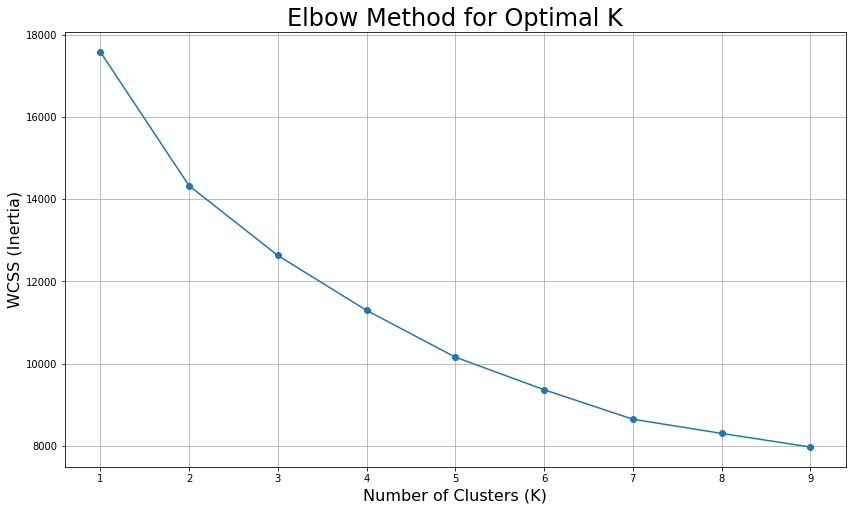

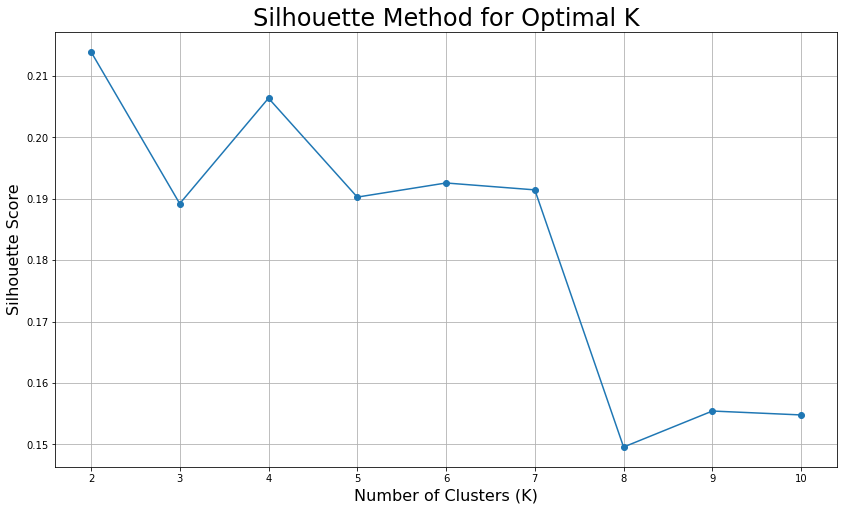

最佳群數為: 4


In [9]:
# 根據圖表結果，觀察到 K=3 或 K=4 是一個合適群數, 選擇使用 K=4 作為示例, 且進一步利用PCA可視化確認
elbow_method(X_scaled, start_k=1, end_k=10)
silhouette_method(X_scaled, start_k=2, end_k=11)
optimal_k = 4
print(f"最佳群數為: {optimal_k}")

## 執行 K-Means 聚類

In [10]:
def KMeans_Method(X_scaled, optimal_k):
    # 執行 K-Means 聚類
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    return kmeans

In [11]:
kmeans = KMeans_Method(X_scaled, optimal_k=4)

## 聚類結果分析

In [12]:
def inference(X_scaled, model):
    cluster_labels = model.predict(X_scaled)
    return cluster_labels

def cluster_analysis(input_data):
    feature_cols = input_data.drop('cluster', axis=1).columns
    cluster_profile = input_data.groupby('cluster')[feature_cols].mean().reset_index()
    scaler = StandardScaler()
    profile_scaled = scaler.fit_transform(cluster_profile.drop('cluster', axis=1)) #每個群組的特徵強度 (標準化Z-Score)
    profile_scaled_df = pd.DataFrame(profile_scaled, columns=feature_cols).T.round(2)
    profile_scaled_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
    return profile_scaled_df

def quality_analysis(input_data):
    quality_analysis = input_data.groupby('cluster')['quality'].agg(['count', 'mean']).round(2)
    quality_analysis.columns = ['count', 'avg_quality']
    return quality_analysis


def pca_scatter_chart(pca_df, x_axis_name, y_axis_name, hue_column_name, file_name):
    # 繪製聚類散點圖
    plt.figure(figsize=(14, 8))
    sns.scatterplot(
        data=pca_df,
        x=x_axis_name,
        y=y_axis_name,
        hue=hue_column_name,
        palette='viridis',
        legend='full',
        alpha=0.7
    )
    plt.title('K-Means Clustering Visualization (via PCA)', fontsize=24)
    plt.xlabel('Principal Component 1', fontsize=16)
    plt.ylabel('Principal Component 2', fontsize=16)
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()

def PCA_analysis(X_scaled, cluster_labels):
    """
    降維至 2D 進行可視化
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # 創建包含 PCA 組件和聚類標籤的新 DataFrame
    pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
    pca_df['cluster'] = cluster_labels
    
    # PCA 可視化分析
    pca_scatter_chart(pca_df, 'Principal Component 1', 'Principal Component 2', 'cluster', 'pca.png')

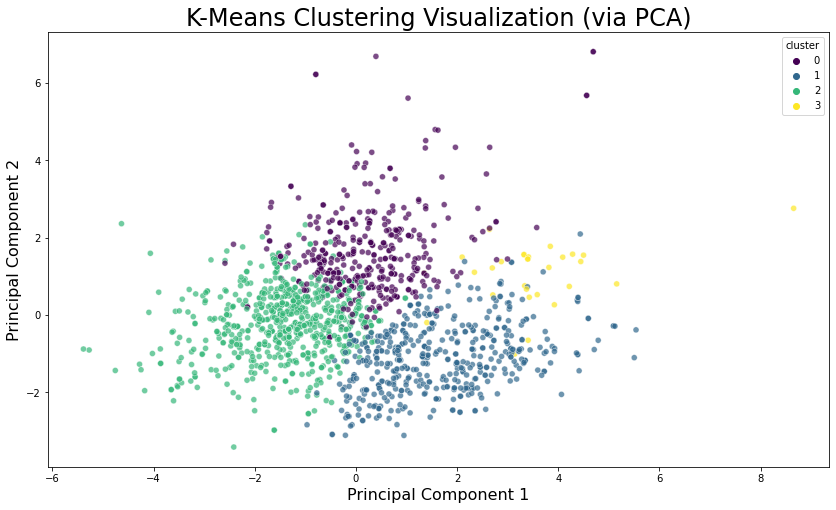

In [13]:
cluster_labels = inference(X_scaled, kmeans)
in_data['cluster'] = cluster_labels
raw_data['cluster'] = cluster_labels

cluster_report = cluster_analysis(in_data)
quality_retport = quality_analysis(raw_data)
pca_df = PCA_analysis(X_scaled, cluster_labels)

## 群組進階分析與風格命名

In [14]:
def plot_grouped_bar(features, cluster_values, file_name):
    clusters = list(cluster_values.keys())
    data = np.array(list(cluster_values.values())).T   # shape: (11 features, 4 clusters)

    x = np.arange(len(features))
    width = 0.18   # 每一根 bar 的寬度

    colors = ["#1F4E79", "#4F81BD", "#548235", "#C9A227"]
    plt.figure(figsize=(14, 8))

    # 依序畫出四個 Cluster 的 bar
    for i, c in enumerate(clusters):
        plt.bar(x + i * width, data[:, i], width, label=f"cluster_{c}", color=colors[i])

    # y=1 的水平線 = 全體平均
    plt.axhline(1.0, linestyle="--", linewidth=1.5, color="#333333")

    plt.xticks(x + width * 1.5, features, rotation=45, ha="right", fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Relative to Global Mean", fontsize=16)
    plt.title("Cluster Feature Profiles (Relative to Global Mean)", fontsize=24)
    plt.legend(frameon=True, fontsize=12)
    plt.tight_layout()
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()
    


def plot_single_cluster_radars(features, cluster_values):
    # 角度配置（每個特徵一個角度）
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 關閉雷達圖的形狀

    colors = ["#1F4E79", "#4F81BD", "#548235", "#C9A227"]

    for cluster_name, vals in cluster_values.items():
        # Convert Series to list before appending the first element to close the radar chart
        values_list = vals.tolist()
        values = values_list + values_list[:1]   # 關閉形狀

        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(111, polar=True)

        ax.plot(angles, values, color=colors[cluster_name], linewidth=2.5)
        ax.fill(angles, values, color=colors[cluster_name], alpha=0.12)

        ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=16, fontweight='bold')
        ax.set_title(f"Cluster {cluster_name}", pad=20, fontsize=24, fontweight="bold")
        ax.set_ylim(0, max(values) * 1.1)  # y 軸範圍稍微留空間
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig(f"cluster {cluster_name}.png", facecolor='white', edgecolor='none', bbox_inches='tight')
        plt.show()


def plot_combined_radar(features, cluster_values, file_name):
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(11, 11))
    ax = plt.subplot(111, polar=True)

    colors = ["#1F4E79", "#4F81BD", "#548235", "#C9A227"]

    for i, (cluster_name, vals) in enumerate(cluster_values.items()):
        values_list = vals.tolist()
        values = values_list + values_list[:1] # 閉合形狀
        ax.plot(
            angles,
            values,
            label=f"Cluster {cluster_name}",
            color=colors[i],
            linewidth=2
        )

    ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=16, fontweight='bold')
    ax.set_title("All Clusters", pad=20, fontsize=24, fontweight="bold")
    ax.set_ylim(0, max(max(v) for v in cluster_values.values()) * 1.1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=True, fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()



def plot_quality_boxplot(df, file_name):
    business_colors = {
          0: "#1F4E79",  # 深藍
          1: "#4F81BD",  # 藍灰
          2: "#548235",  # 商務綠
          3: "#C9A227"   # 商務金
      }
    data = []
    labels = []
    colors = []
    for c in sorted(df['cluster'].unique()):
        data.append(df[df['cluster'] == c]['quality'].values)
        labels.append(f"Cluster {c}")
        colors.append(business_colors[c])
    fig = plt.figure(figsize=(12, 6))
    bp = plt.boxplot(data, labels=labels, patch_artist=True)
    
    # ✅ 商業風填色
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")
        patch.set_linewidth(1.2)
        
    # 商業風線條加粗
    for element in ['whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_linewidth(1.2)
            line.set_color("black")
            
    plt.xlabel("Cluster", fontsize=16)
    plt.ylabel("Wine Quality Score", fontsize=16)
    plt.title("Quality Distribution Across Clusters", fontsize=24)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()

def plot_quality_mean_bar(df, file_name):
    business_colors = {
          0: "#1F4E79",  # 深藍
          1: "#4F81BD",  # 藍灰
          2: "#548235",  # 商務綠
          3: "#C9A227"   # 商務金
      }
    group_mean = df.groupby("cluster")["quality"].mean()
    colors = [business_colors[c] for c in group_mean.index]
    plt.figure(figsize=(12, 6))
    plt.bar(group_mean.index.astype(str), group_mean.values, color=colors, edgecolor="black", linewidth=1.2)
    plt.xlabel("Cluster", fontsize=16)
    plt.ylabel("Average Wine Quality Score", fontsize=16)
    plt.title("Average Quality Score of Each Cluster", fontsize=24)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(file_name, facecolor='white', edgecolor='none', bbox_inches='tight')
    plt.show()


In [15]:
feature_profile = in_data.groupby('cluster').mean()
overall_mean = in_data.drop('cluster', axis=1).mean()
relative_profile = feature_profile.div(overall_mean, axis=1).round(2).T
relative_profile

cluster,0,1,2,3
fixed acidity,0.98,1.22,0.86,1.02
volatile acidity,1.01,0.75,1.16,1.00
citric acid,1.07,1.73,0.44,1.82
residual sugar,1.22,1.03,0.87,0.78
chlorides,0.99,0.96,0.90,4.06
free sulfur dioxide,1.71,0.67,0.84,0.96
total sulfur dioxide,1.92,0.62,0.75,1.38
density,1.00,1.00,1.00,1.00
pH,0.99,0.97,1.03,0.92
sulphates,0.95,1.09,0.92,1.92


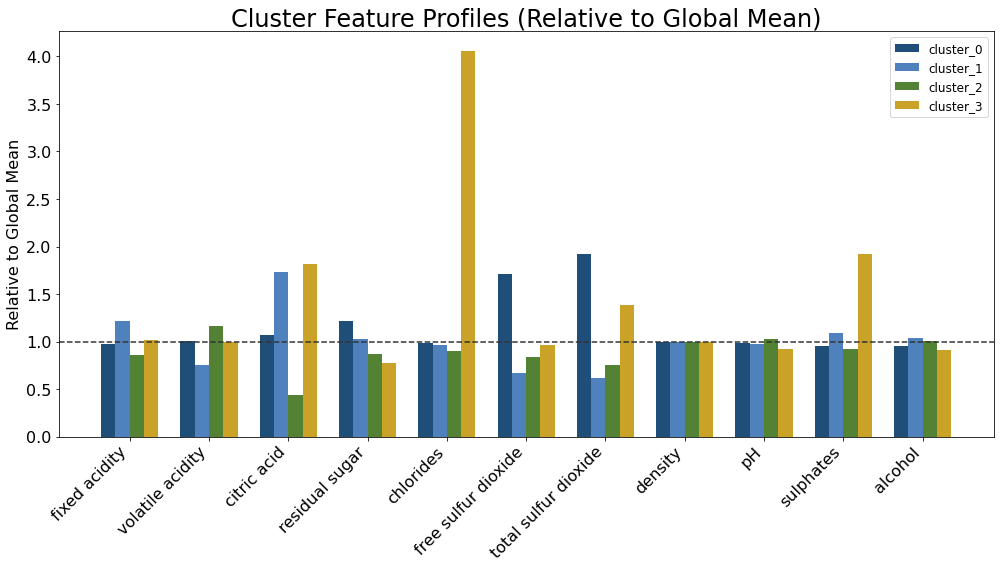

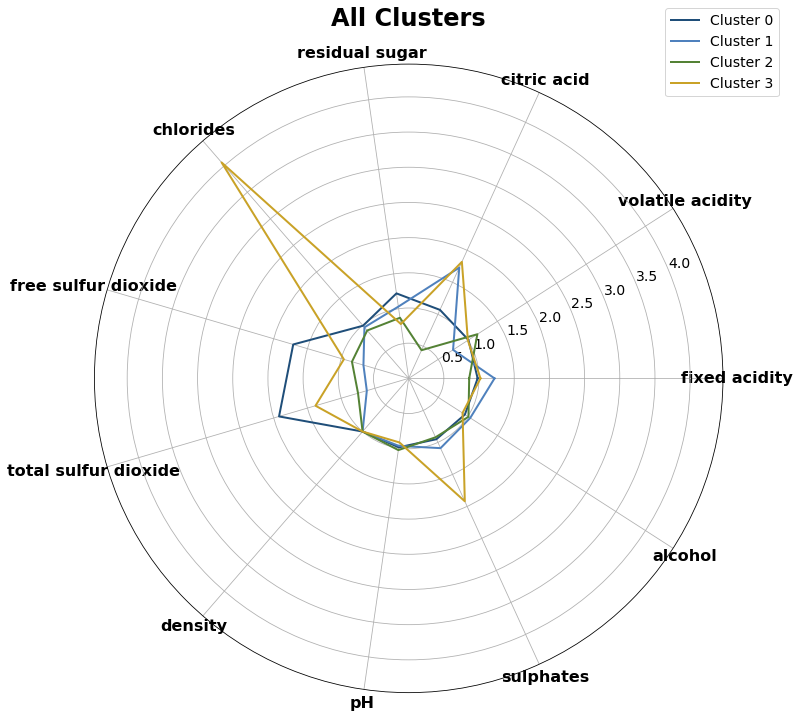

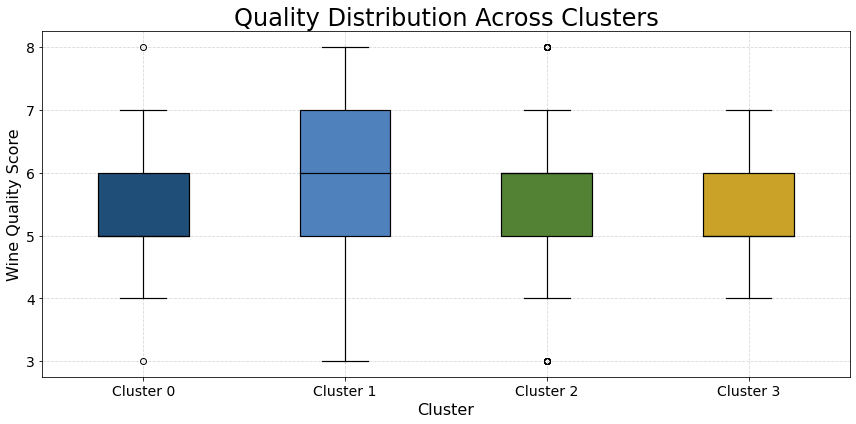

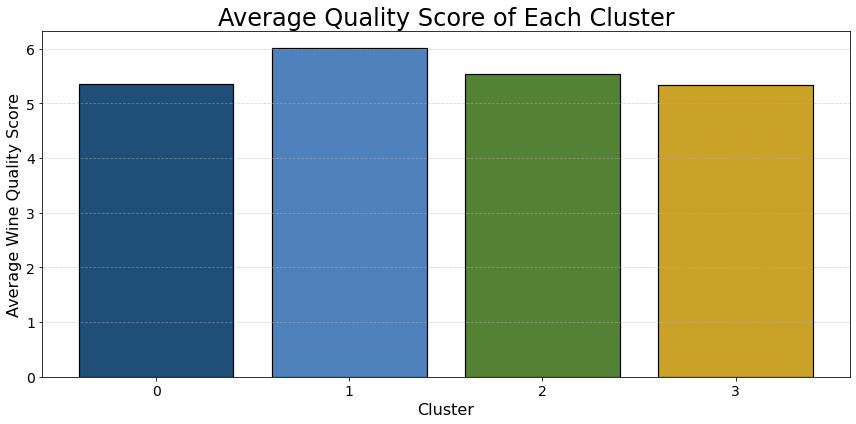

In [16]:
features = relative_profile.index.tolist()
cluster_values = dict(relative_profile)
plot_grouped_bar(features, cluster_values, file_name="cluster_feature_bar.png")
# plot_single_cluster_radars(features, cluster_values)
plot_combined_radar(features, cluster_values, file_name="all_cluster.png")
plot_quality_boxplot(raw_data, file_name="clusters_quality_distribution.png")
plot_quality_mean_bar(raw_data, file_name="clusters_quality_score.png")

## Summary
---


| 群    | 風格名稱   | 關鍵特徵      | 核心化學特性 |
| ---- | ------ | --------- | ------ |
| 🟣 0 | 平衡經典型  | 無極端值      | 結構中庸穩定 |
| 🔵 1 | 高酒精圓潤型 | 酒精↑、揮發酸↓  | 成熟果香厚  |
| 🟢 2 | 高酸礦物型  | 酸↑、pH↓、硫↓ | 清爽、自然派 |
| 🟡 3 | 甜潤保存型  | 糖↑、硫↑     | 甜口、長保存 |
